# Dem4Cli : part 1 demo

## Description
Gridscale demographics code v2.0, 2024 update

Preprocess WCDE cohort size data (1950-2100, historical + ssp1,2 or 3, http://dataexplorer.wittgensteincentre.org/wcde-v2/) and gridded population data (1850-2100, ISIMIP2b hist-ssp2 or ISIMIP3b hist-ssp1 or hist-ssp3) to get gridded demographic data (number of people of each age in each location each year).

Isipedia fractional country masks are used to match the datasets (Perrette 2023, https://github.com/ISI-MIP/isipedia-countries). Metadata on income levels and regions from World Bank (WB 2023, https://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html)

rosa.pietroiusti@vub.be

### Note on countries covered

WCDE provides demographic information for 202 countries/administrative units + the world average, for the year 1950-2100 for three SSP scenarios (ssp1, ssp2, ssp3). Of these, 197 are available in the isipedia country mask. Data is matched based on these countries/administrative units. This corresponds to ~99.97% of the global population, (i.e. the missing areas omitted from the analysis only amount to 0.03% of the global population).

These 197 countries/administrative units correspond to 184 UN member/observer countries, plus 13 countries/administrations that are not UN sovereign member countries (disputed territories, special adminstrative regions and overseas administrative units, e.g., Hong Kong, French Guyana, Taiwan, Puerto Rico, La Reunion...).

See: notebook check-countries-population.ipynb for these checks. 

## To do
- get all WB income/region data for also non-195 countries into df_metadata
- later: add option to include sex division in demographics
- later: make a separate fxn/notebook for lifetime accumulation



In [1]:

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import pickle as pk
from scipy import interpolate
#import regionmask
import glob, os, re
import openpyxl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 80)
%matplotlib inline 

from population_demographics import * 

In [2]:
df_metadata = load_country_metadata()
df_metadata

,country,country_iso3,country_code,region,income_group
0,Afghanistan,AFG,3,South Asia,Low income
1,Albania,ALB,103,Europe & Central Asia,Upper middle income
2,Algeria,DZA,203,Middle East & North Africa,Upper middle income
3,Andorra,AND,403,Europe & Central Asia,High income
4,Angola,AGO,503,Sub-Saharan Africa,Lower middle income
...,...,...,...,...,...
190,Venezuela (Bolivarian Republic of),VEN,22503,Latin America & Caribbean,NaN
191,Viet Nam,VNM,22603,East Asia & Pacific,Lower middle income
192,Yemen,YEM,23003,Middle East & North Africa,Low income
193,Zambia,ZMB,23103,Sub-Saharan Africa,Lower middle income


In [3]:
df_cohort_sizes_ssp1, ages, years = load_cohort_sizes(ssp=1)

df_cohort_sizes_ssp2, none, none = load_cohort_sizes(ssp=2)

df_cohort_sizes_ssp3, none, none = load_cohort_sizes(ssp=3)

In [4]:
df_cohort_sizes_ssp2

,2_1950,2_1955,2_1960,2_1965,2_1970,2_1975,2_1980,2_1985,2_1990,2_1995,...,102_2055,102_2060,102_2065,102_2070,102_2075,102_2080,102_2085,102_2090,102_2095,102_2100
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1291.6,1355.1,1539.5,1762.1,2025.6,2326.7,2484.4,2276.9,2377.9,3325.5,...,0.2,0.2,0.3,0.4,0.5,0.7,0.9,1.1,1.6,2.4
Albania,180.8,222.5,272.9,309.7,312.3,324.8,335.2,355.5,388.5,334.4,...,3.2,5.5,8.0,9.7,11.8,14.7,19.1,20.3,24.7,35.4
Algeria,1403.1,1830.6,2081.8,2398.0,2692.6,3086.2,3528.0,3893.8,3994.2,3734.3,...,15.7,23.0,35.4,52.8,78.8,123.7,179.8,235.8,281.4,297.1
Angola,739.2,1023.5,1095.3,1196.5,1298.7,1515.1,1810.3,2122.6,2438.5,2799.6,...,0.4,0.5,0.6,0.8,1.1,1.5,2.1,3.0,4.2,6.1
Antigua and Barbuda,6.6,8.4,8.9,9.2,9.9,9.3,7.3,7.2,7.4,6.8,...,0.0,0.1,0.1,0.1,0.1,0.1,0.2,0.2,0.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Western Sahara,2.4,3.3,5.4,8.7,13.2,13.3,23.0,29.2,31.8,34.6,...,0.0,0.0,0.1,0.1,0.2,0.3,0.4,0.5,0.7,0.9
World,338387.2,405612.1,432642.8,480601.0,523700.8,543302.0,548178.6,592792.3,644867.3,623061.1,...,5799.9,7789.0,10822.7,14499.7,18443.9,22134.8,28115.2,36321.0,42244.2,48218.6
Yemen,770.2,777.9,860.3,978.0,1173.4,1348.4,1709.7,2115.3,2603.1,3082.0,...,0.3,0.4,0.5,0.7,1.1,2.1,3.4,5.2,7.8,10.2


In [5]:
da_population_ssp1 = load_population(isimip_round=3, ssp=1)

da_population_ssp2 = load_population(isimip_round=2, ssp=2)

da_population_ssp3 =load_population(isimip_round=3, ssp=3)

opening isimip3 - ssp1
opening isimip2 - ssp2
opening isimip3 - ssp3


In [6]:
da_countrymasks = load_countrymasks_fillcoasts()

In [7]:
df_countries_matched = match_country_names_all_mask_frac()

Unmatched ISIMIP countries (without WCDE data) after all merges:
                   country           country_wb
194                Andorra              Andorra
196               Dominica             Dominica
199                  Palau                Palau
7            Liechtenstein        Liechtenstein
8         Marshall Islands     Marshall Islands
9                   Monaco               Monaco
10                   Nauru                Nauru
12   Saint Kitts and Nevis  St. Kitts and Nevis
13              San Marino           San Marino
14                  Tuvalu               Tuvalu
Unmatched WCDE countries after all merges:
                                   country_wcde
2                                         Aruba
3                               Channel Islands
4                                       Curaçao
5  Macao Special Administrative Region of China
6                                         World
Unmatched ISIMIP mask countries (geojson + frac mask) after all merges:
    

In [8]:
da_cohort_size_ssp1 = interpolate_cohortsize_countries(df_cohort_sizes_ssp1,
                                                 ages,
                                                 years)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


In [9]:
da_pop_demographics = get_gridscale_demographics(da_population_ssp1,
                                                 da_countrymasks,
                                                 df_countries_matched,
                                                 da_cohort_size_ssp1,
                                                startyear=2000,
                                                endyear=2005)

Afghanistan
Albania
Algeria
Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
**iso not in mask
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia (Plurinational State of)
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Republic
Chad
Channel Islands
**iso not in mask
Chile
China
Colombia
Comoros
Congo
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Curaçao
**iso not in mask
Cyprus
Czech Republic
Democratic People's Republic of Korea
Democratic Republic of the Congo
Denmark
Djibouti
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Fiji
Finland
France
French Guiana
French Polynesia
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hong Kong Special Administrative Region of China
Hungary
Iceland
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ir

In [10]:

da_pop_demographics

<xarray.DataArray (time: 6, lat: 360, lon: 720, ages: 105)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) int64 2000 2001 2002 2003 2004 2005
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

## wrapper function that runs everything

In [11]:
import time
tic = time.time()

da_pop_demographics_ssp2 = population_demographics_gridscale_global(startyear=2000,
                                                                    endyear=2003,
                                                                    isimip_round=2, 
                                                                    ssp=2)

toc = time.time()
print(toc-tic)

opening isimip2 - ssp2
loading country masks
interpolating cohort sizes per country
calculating gridscale demographics
166.2183222770691


## check 


In [12]:
# open saved output

da = xr.open_dataarray('output/ISIMIP3-SSP3/population_demographics_histsoc_ssp3_isimip3_wcde_1950_2000.nc')

In [13]:
da

<xarray.DataArray (time: 51, lat: 360, lon: 720, ages: 105)>
[1388016000 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) int64 1950 1951 1952 1953 1954 ... 1996 1997 1998 1999 2000
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

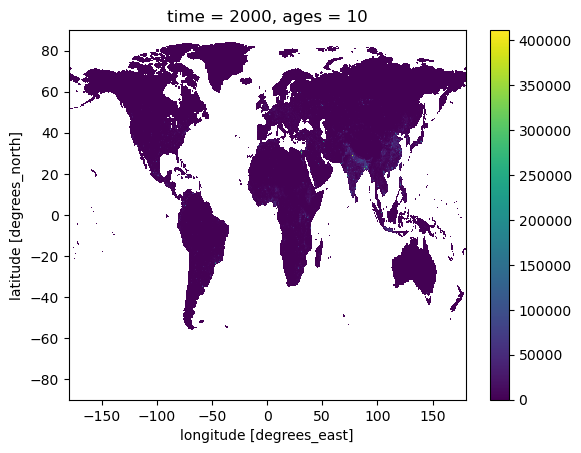

In [14]:
da.sel(time=2000,ages=10).plot()

In [15]:
da.sel(time=2000).sum(dim=['ages','lat','lon'])

<xarray.DataArray ()>
array(6.13940693e+09)
Coordinates:
    time     int64 2000